In [3]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [ ]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

base_url = "https://openrouter.ai/api/v1"
MODEL = "gpt-4.1-mini"
openai = OpenAI(
    base_url=base_url,
    api_key=openai_api_key
)

DB = "prices.db"

OpenAI API Key exists and begins sk-or-v1


In [ ]:
messages = [
    {'role': 'system', 'content': "You are a helpful assistant that can answer questions and help with tasks."},
    {'role': 'user', 'content': "What is the capital of Tanzania?"}
    ]

response = openai.chat.completions.create(
    model=MODEL,
    messages=messages
)

print(response.choices[0].message.content)


In [8]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

get_ticket_price("london")

DATABASE TOOL CALLED: Getting price for london


'Ticket price to london is $799.0'

In [ ]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [10]:
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses

In [ ]:
system_message ="""You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so."""


def _history_to_messages(history):
    history = history or []
    if not history:
        return []

    # Newer Gradio: list of {role, content}
    if isinstance(history[0], dict):
        return [
            {"role": str(h.get("role")), "content": str(h.get("content"))}
            for h in history
            if h.get("role") and h.get("content") is not None
        ]

    # Older Gradio: list of (user, assistant) tuples
    msgs = []
    for user_msg, assistant_msg in history:
        if user_msg is not None and str(user_msg).strip() != "":
            msgs.append({"role": "user", "content": str(user_msg)})
        if assistant_msg is not None and str(assistant_msg).strip() != "":
            msgs.append({"role": "assistant", "content": str(assistant_msg)})
    return msgs


def chat_basic(message, history):
    messages = [{"role": "system", "content": system_message}]
    messages += _history_to_messages(history)
    messages.append({"role": "user", "content": message})

    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    while response.choices[0].finish_reason == "tool_calls":
        msg_obj = response.choices[0].message
        responses = handle_tool_calls(msg_obj)

        # Add assistant tool-call message as a plain dict
        tool_calls = [
            {
                "id": tc.id,
                "type": "function",
                "function": {"name": tc.function.name, "arguments": tc.function.arguments},
            }
            for tc in msg_obj.tool_calls
        ]
        messages.append({"role": "assistant", "content": msg_obj.content, "tool_calls": tool_calls})

        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    return response.choices[0].message.content

In [15]:
gr.ChatInterface(fn=chat_basic).launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for Nairobi


### Image Generation Tool

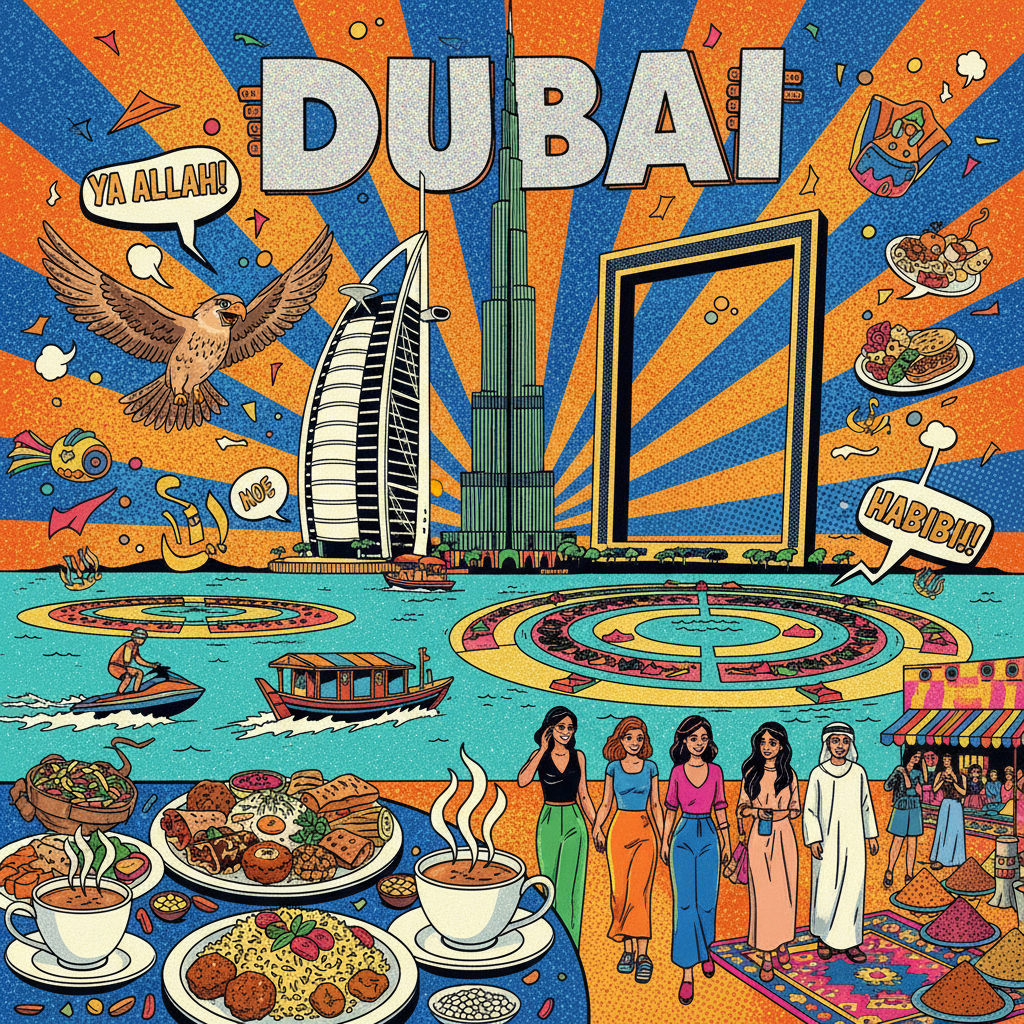

In [123]:
import os
import base64
from io import BytesIO
from PIL import Image
import requests

# Assuming you already have:
# openrouter_api_key = os.getenv('OPENROUTER_API_KEY')

def artist(city):
    # function that takes a city name and returns an image of the city
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {openrouter_api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost",  # Optional: helps with OpenRouter rankings
        "X-Title": "Artist App"
    }

    prompt_text = (
        f"Generate a vibrant pop-art style vacation scene in {city}, "
        f"showing famous tourist spots, landmarks, unique culture, food, "
        f"energy, and atmosphere of the city. Bold colors, high contrast, fun and dynamic composition."
    )

    payload = {
        "model": "google/gemini-2.5-flash-image",  # Stable version — try "-preview" only if this fails
        "modalities": ["text", "image"],           # Order often matters — text first helps
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text}
                ]
            }
        ]
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code != 200:
        raise Exception(f"API error {response.status_code}: {response.text}")

    result = response.json()

    # Extract image if present
    choices = result.get("choices", [])
    if not choices:
        raise ValueError("No choices in response")

    message = choices[0].get("message", {})
    images = message.get("images", [])

    if not images:
        # Debug fallback — print what we got
        print("No images found. Message content:", message.get("content"))
        print("Full message keys:", list(message.keys()))
        raise ValueError("No image generated — check prompt/model/credits")

    # Take the first image (usually only one)
    image_obj = images[0]
    image_data_url = image_obj.get("image_url", {}).get("url", "")

    if not image_data_url.startswith("data:image"):
        raise ValueError(f"Unexpected image format: {image_data_url[:50]}...")

    # Decode base64
    base64_str = image_data_url.split(",", 1)[1]
    image_bytes = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_bytes))


# Usage — exactly as you wanted
image = artist("nice image about Dubai")
display(image)  # In Jupyter — or image.show() elsewhere

### Audio Tool

In [ ]:
import os
from openai import OpenAI          # for TTS only
from anthropic import Anthropic    # for Claude text generation

# Assuming your .env has:
# ANTHROPIC_API_KEY=sk-ant-...
# OPENAI_API_KEY=sk-...

anthropic_client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def talker(message, claude_model="claude-sonnet-4-6"):  # ← Updated default to current model
    """
    1. Ask Claude to generate/rewrite the spoken response (add personality, fix grammar, etc.)
    2. Use OpenAI TTS to turn it into audio.
    Returns MP3 bytes.
    """
    # Let Claude prepare/enhance the spoken text
    claude_response = anthropic_client.messages.create(
        model=claude_model,  # Now using a valid 2026 model
        max_tokens=300,
        messages=[
            {
                "role": "user",
                "content": f"Rewrite this as natural, spoken English ready for text-to-speech (keep it concise and friendly): '{message}'"
            }
        ]
    )
    spoken_text = claude_response.content[0].text.strip()
    print(f"Claude prepared text: {spoken_text}")

    # Generate audio with OpenAI TTS (unchanged)
    audio_response = openai_client.audio.speech.create(
        model="gpt-4o-mini-tts",   # or "tts-1-hd" if you prefer higher quality
        voice="onyx",              # deep male voice
        input=spoken_text
    )
    return audio_response.content

# Example usage — now works!
audio_bytes = talker("Hello, how are you?")
# Or explicitly: talker("Hello, how are you?", claude_model="claude-opus-4-6") for max intelligence

if audio_bytes:
    with open("claude_hello.mp3", "wb") as f:
        f.write(audio_bytes)
    print("Audio saved as claude_hello.mp3")

In [ ]:
from openai import OpenAI

client = OpenAI()


def talker(message: str) -> bytes:
    """
    Convert a text message into spoken audio using OpenAI TTS.

    :param message: The text the AI agent wants to speak.
    :return: Audio bytes for playback or streaming.
    """
    response = client.audio.speech.create(
        model="gpt-4o-mini-tts",
        voice="onyx",
        
        input=message
    )

    return response.content

### Using Eleven Labs, requires payment

In [ ]:
from elevenlabs.client import ElevenLabs
from elevenlabs.play import play
import os

from dotenv import load_dotenv

load_dotenv(override=True)


client = ElevenLabs(
    api_key=os.getenv("ELEVENLABS_API_KEY")
    
)
print(os.getenv("ELEVENLABS_API_KEY"))

audio = client.text_to_speech.convert(
    text="The first move is what sets everything in motion.",
    voice_id="hILdTfuUq4LRBMrxHERr",
    model_id="eleven_v3",
    output_format="mp3_44100_128",
)

play(audio)

### Tring to use a multi-modal model

In [112]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

In [121]:
import json
import tempfile


def _gradio_history_to_messages(history):
    """Normalize Gradio ChatInterface history into OpenAI messages."""
    history = history or []
    if not history:
        return []

    # Newer Gradio can store messages as dicts: {role, content}
    if isinstance(history[0], dict):
        msgs = []
        for h in history:
            role = h.get("role")
            content = h.get("content")
            if role and content is not None:
                msgs.append({"role": str(role), "content": str(content)})
        return msgs

    # Older Gradio stores tuples: [(user, assistant), ...]
    msgs = []
    for user_msg, assistant_msg in history:
        if user_msg is not None and str(user_msg).strip() != "":
            msgs.append({"role": "user", "content": str(user_msg)})
        if assistant_msg is not None and str(assistant_msg).strip() != "":
            msgs.append({"role": "assistant", "content": str(assistant_msg)})
    return msgs


def chat(message, history):
    """Return (assistant_text, voice_audio_path, image) for Gradio ChatInterface."""
    user_message = (message or "").strip()
    messages = [{"role": "system", "content": system_message}]
    messages += _gradio_history_to_messages(history)
    messages.append({"role": "user", "content": user_message})

    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    cities = []
    image = None

    while response.choices[0].finish_reason == "tool_calls":
        msg_obj = response.choices[0].message

        assistant_tool_calls = []
        for tc in msg_obj.tool_calls:
            assistant_tool_calls.append(
                {
                    "id": tc.id,
                    "type": "function",
                    "function": {"name": tc.function.name, "arguments": tc.function.arguments},
                }
            )

        messages.append(
            {
                "role": "assistant",
                "content": msg_obj.content,
                "tool_calls": assistant_tool_calls,
            }
        )

        tool_messages, cities = handle_tool_calls_and_return_cities(msg_obj)
        messages.extend(tool_messages)

        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content

    # Voice (write bytes to a temp wav file for Gradio)
    audio_bytes = talker(reply)
    with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as f:
        f.write(audio_bytes)
        audio_path = f.name

    if cities:
        image = artist(cities[0])

    return reply, audio_path, image


In [122]:
gr.ChatInterface(fn=chat).launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


Claude prepared text: Here's a natural, spoken version:

"I'm not able to show images, but Nairobi has some stunning views! Think Nairobi National Park with wild animals and city skyscrapers all in the same frame. Want me to describe a specific spot for you?"


Traceback (most recent call last):
  File "c:\Users\maina\miniconda3\envs\llms\Lib\site-packages\gradio\queueing.py", line 766, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\maina\miniconda3\envs\llms\Lib\site-packages\gradio\route_utils.py", line 355, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\maina\miniconda3\envs\llms\Lib\site-packages\gradio\blocks.py", line 2157, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\maina\miniconda3\envs\llms\Lib\site-packages\gradio\blocks.py", line 1632, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\maina\miniconda3\envs\llms\Lib\site-packages\gradio\utils.py", line 1005, in async_wrapper
    response = await f(*args, **kwargs)
        